In [7]:

#Importing neccessary packages

import numpy                 # linear algebra, vectors and matrices
from pandas import read_csv  # tables and data manipulations-data processing-CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
from math import sqrt
import matplotlib.pyplot as plt # plots
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings              # off warning mode
warnings.filterwarnings('ignore')

In [2]:

#Loading dataset of Chrysler-Canada and spliting data into train & validation data


Chry=read_csv("CHRYSLER_SALES.csv", header=0, index_col=0)
split_point = len(Chry) - 12
dataset, validation = Chry[0:split_point], Chry[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')
dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)
Chry.head()

Dataset 156, Validation 12


,SALES
DATE,
2005-01,33918
2005-02,53575
2005-03,60382
2005-04,61332
2005-05,61696


In [3]:

#Autoregressive Integrated Moving Average Model(Model Evaluation)


# loading the data
Chry= read_csv('dataset.csv')

# Preparing the data
X = Chry.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=16529.000, Expected=15427
>Predicted=15427.000, Expected=22497
>Predicted=22497.000, Expected=23559
>Predicted=23559.000, Expected=21244
>Predicted=21244.000, Expected=18577
>Predicted=18577.000, Expected=23974
>Predicted=23974.000, Expected=17604
>Predicted=17604.000, Expected=54016
>Predicted=54016.000, Expected=34726
>Predicted=34726.000, Expected=31879
>Predicted=31879.000, Expected=29674
>Predicted=29674.000, Expected=26863
>Predicted=26863.000, Expected=20792
>Predicted=20792.000, Expected=28070
>Predicted=28070.000, Expected=24850
>Predicted=24850.000, Expected=22222
>Predicted=22222.000, Expected=18766
>Predicted=18766.000, Expected=25513
>Predicted=25513.000, Expected=20696
>Predicted=20696.000, Expected=25083
>Predicted=25083.000, Expected=33905
>Predicted=33905.000, Expected=27836
>Predicted=27836.000, Expected=29070
>Predicted=29070.000, Expected=27249
>Predicted=27249.000, Expected=19978
>Predicted=19978.000, Expected=28678
>Predicted=28678.000, Expected=25251
>

In [4]:

#Summary statistics

Chry= read_csv('dataset.csv')
print(Chry.describe())

             SALES
count    156.00000
mean   28329.75000
std    13787.61649
min     9046.00000
25%    18191.00000
50%    24151.00000
75%    34436.75000
max    65594.00000


In [5]:

#Evaluating Performance of ARIMA (Grid Search hyper parameters)


# Differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# Inverted differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Evaluating  ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Preparing the training dataset 
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Make predictions 
    predictions = list()
    for t in range(len(test)):
        
        # Differenced data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
        
    # Calculation for sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# Evaluating combinations of p, d and q values for ARIMA model

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# Evaluating parameters

p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(Chry.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=7808.964
ARIMA(0, 0, 2) RMSE=7638.686
ARIMA(0, 0, 3) RMSE=7009.305
ARIMA(0, 1, 1) RMSE=6620.644
ARIMA(0, 1, 2) RMSE=6839.802
ARIMA(0, 1, 3) RMSE=6824.739
ARIMA(0, 2, 1) RMSE=7606.483
ARIMA(1, 0, 0) RMSE=6992.064
ARIMA(1, 0, 1) RMSE=6462.258
ARIMA(1, 1, 0) RMSE=6935.498
ARIMA(1, 2, 0) RMSE=10046.404
ARIMA(2, 0, 0) RMSE=6633.703
ARIMA(2, 1, 0) RMSE=6788.264
ARIMA(2, 1, 1) RMSE=6834.322
ARIMA(2, 1, 2) RMSE=7085.645
ARIMA(2, 2, 0) RMSE=8796.661
ARIMA(2, 2, 1) RMSE=6960.726
ARIMA(3, 0, 0) RMSE=6574.719
ARIMA(3, 0, 1) RMSE=6612.567
ARIMA(3, 0, 2) RMSE=6818.130
ARIMA(3, 1, 0) RMSE=6862.643
ARIMA(3, 1, 1) RMSE=6861.494
ARIMA(3, 1, 2) RMSE=6811.987
ARIMA(3, 1, 3) RMSE=7078.349
ARIMA(3, 2, 0) RMSE=8252.857
ARIMA(3, 2, 1) RMSE=6932.257
Best ARIMA(1, 0, 1) RMSE=6462.258


                  0
count     78.000000
mean     -70.602264
std     7859.186820
min   -29953.453125
25%    -3662.233887
50%     -432.605469
75%     3411.946777
max    38513.300781


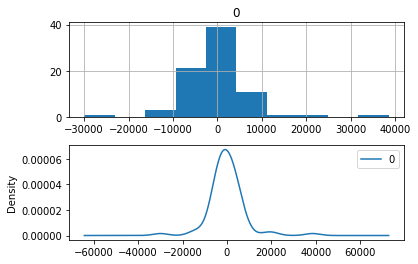

In [10]:

#ARIMA (Residual error review)
    
# Errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

# Plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()